# Choose sectors, products and diversification paths
This notebook selects target products and sectors for diversification analysis. It focuses on identifying products based on strategic indicators like PCI, density, and proximity—both at the state and firm level.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Select which data and aggregation to use

data_choice = "trade" # trade / labor
labor_aggregation = "state" # state / metropolitan_area

In [3]:
# Importo tipografía Punto
import os
path = os.path.join(os.path.expanduser('~'), 'Documents/Proyectos/herramientas/')
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
font_dir = [path + 'Raleway/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Raleway'
font_manager.fontManager

## 1. Read Data

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format) 

In [5]:
# Directory structure and read database

if data_choice == "trade":
    DATASETS_DIR = './datasets_trade/'
    OUTPUTS_DIR = "./outputs_trade/"
    variable = "trade_value"
    code = "HS6"
    location = 'location'
    
elif data_choice == "labor":
    if labor_aggregation == "state":
        DATASETS_DIR = './datasets_labor_states/'
        OUTPUTS_DIR = "./outputs_labor_states/"
        variable = "EMP"
        location = "STATE_NAME"
        code = "NAICS2017"
    
    elif labor_aggregation == "metropolitan_area":
        DATASETS_DIR = './datasets_labor_metropolitan_area/'
        OUTPUTS_DIR = "./outputs_labor_metropolitan_area/"
        variable = "EMP"

In [6]:
relative_density = pd.read_parquet(OUTPUTS_DIR + "relative_density.parquet",engine='fastparquet')

pci = pd.read_parquet(OUTPUTS_DIR + "pci.parquet",engine='fastparquet')

relative_cog = pd.read_parquet(OUTPUTS_DIR + "relative_cog.parquet",engine='fastparquet')

products = pd.read_parquet(OUTPUTS_DIR + "codes.parquet",engine='fastparquet')

locations = pd.read_parquet(OUTPUTS_DIR + "locations.parquet",engine='fastparquet')

rca = pd.read_parquet(OUTPUTS_DIR + "RCA.parquet",engine='fastparquet')

mpa = pd.read_parquet(OUTPUTS_DIR + "Mpa.parquet",engine='fastparquet')

value_level = pd.read_parquet(OUTPUTS_DIR + "value_level.parquet",engine='fastparquet')

eci = pd.read_parquet(OUTPUTS_DIR + "eci.parquet",engine='fastparquet')

proximity = pd.read_parquet(OUTPUTS_DIR + "proximity.parquet",engine='fastparquet')

In [7]:
codes = products.iloc[:, 0].astype(str) 

rel_cog_long = (relative_cog.stack().rename("relative_cog").to_frame())
rel_density_long = relative_density.stack().rename("density").to_frame()
rca_long         = rca.stack().rename("rca").to_frame()
mpa_long         = mpa.stack().rename("mcp").to_frame()
value_long       = value_level.stack().rename(variable).to_frame()

df_long = (rel_cog_long.join(rel_density_long).join(rca_long).join(mpa_long).join(value_long).reset_index())
df_long = df_long.rename(columns={df_long.columns[0]: "location", df_long.columns[1]: "code"})

df_pci = pd.DataFrame({"code": codes.values})
df_pci["pci"] = (pci.values)

df_full = df_long.merge(df_pci, on="code", how="left")
df_full.head()

,location,code,relative_cog,density,rca,mcp,trade_value,pci
0,Afghanistan,010121,-0.71,-0.18,0.00,0,2.00,0.67
1,Afghanistan,010221,0.24,0.64,0.20,0,15775.00,-0.07
2,Afghanistan,010619,0.03,0.23,0.28,0,6178.00,-0.07
3,Afghanistan,010641,-0.32,2.69,20.83,1,126005.00,-0.59
4,Afghanistan,020120,0.74,0.36,0.00,0,1000.00,-0.11


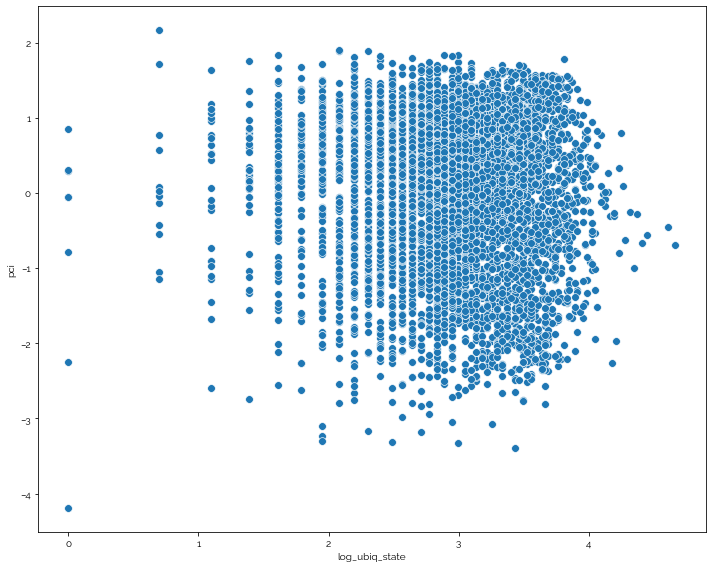

In [8]:
df_full["presence"] = (df_full["rca"] >= 1).astype(int)

ubiq = df_full.loc[df_full["presence"] == 1].groupby("code")["location"].nunique().rename("ubiq_state").reset_index()

pci_all = (df_full[["code", "pci"]].drop_duplicates().merge(ubiq, on="code", how="left"))
pci_all["log_ubiq_state"] = np.log(pci_all["ubiq_state"])

plt.figure(figsize=(10,8))
sns.scatterplot(data=pci_all, x="log_ubiq_state", y="pci", s=60)
plt.tight_layout()
plt.show()

In [9]:
pci_summary = df_full.loc[(df_full.mcp == 1)].groupby("location").agg(
    avg_pci=("pci", "mean"),
    median_pci=("pci", "median"),
    product_count=("NAICS_2022", "count"),
    high_complex_products=("pci", lambda x: (x > 1).sum()),
    low_complex_products=("pci", lambda x: (x < -1).sum())
).reset_index()

pci_summary.sort_values(by="avg_pci", ascending=False)

KeyError: "Column(s) ['NAICS_2022'] do not exist"

In [ ]:
df_full["naics_level2"] = df_full["NAICS_2022"].str[:2]
df_full = df_full.merge(naics_equivalence[["naics_code", "naics_description"]], left_on="naics_level2", right_on="naics_code", how="left")

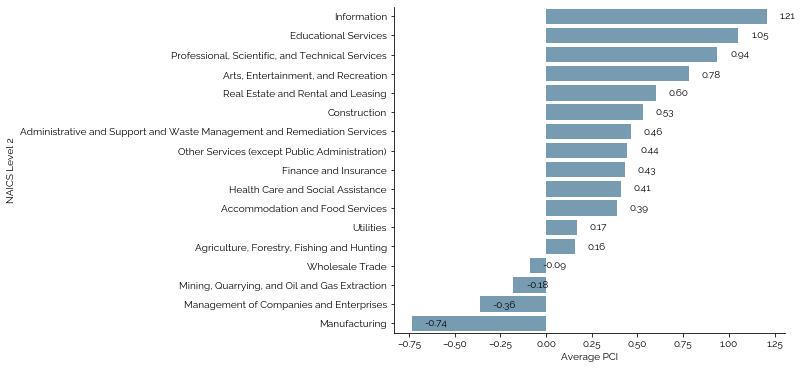

In [ ]:
df_unique_products = df_full.drop_duplicates(subset=["NAICS_2022"])
pci_by_section = df_unique_products.groupby("naics_description")["pci"].mean().reset_index()
pci_by_section = pci_by_section.sort_values(by="pci", ascending=False).reset_index()

fig = plt.figure(figsize=(7, 6))
sns.barplot(data=pci_by_section, x="pci", y="naics_description", color="#6d9ebc")
plt.xlabel("Average PCI")
plt.ylabel("NAICS Level 2")
for index, row in pci_by_section.iterrows():
    plt.text(row["pci"] + 0.07, index, f"{row['pci']:.2f}", va='center')
sns.despine()
#fig.savefig("figs/pci_section.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()